# <span style="font-size:1.5em;"> Forecasting Air Quality in New York City
Author: Angela Kim

---

# <span style="font-size:1.2em;"> Contents

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>
    
- <a href="#Business Problem">Business Problem</a>
    
- <a href="#Imports">Imports</a>

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a>
    
- <a href="#Modeling">Modeling</a>

- <a href="#Visualizations">Visualizations</a>
    
- <a href="#Conclusion">Conclusion</a>

- <a href="#Next Steps">Next Steps</a>

---

# <span style="font-size:1.2em;"> <a id="Overview">Overview</a>

> This project analyzes air pollution data of four major gas pollutants--ground-level ozone (O₃), carbon monoxide (CO), nitrogen dioxide (NO₂), and sulfur dioxide (SO₂)--and creates time series models to forecast future air quality in New York City.
>
> Note: For ease of reference, I will use O3, CO, NO2, and SO2 when naming the pollutants, knowing full well that technically they are not accurate chemical formulas.

# <span style="font-size:1.2em;"> <a id="Business Problem">Business Problem</a>

> Air pollution is a huge problem for everyone. According to the Environmental Defense Fund (EDF), air pollution is currently the biggest environmental risk of premature death. It is highly linked to cardiovascular and respiratory disease and worsens symptoms of susceptible populations.
>
> Not only is air pollution bad for public health, it’s also bad for the economy. Air pollution costs the US roughly 5% of its annual GDP in damages ($790 billion in 2014). The highest costs come from premature deaths. A study by Anthony Heyes, Matthew Neidell, and Soodeh Saberian even suggests that air pollution affects the stock market.
>
> Air pollution also exacerbates the race-class divide. Racial and ethnic minorities are exposed to higher levels of air pollution, especially in highly segregated neighborhoods. Urban areas are more polluted than rural areas, which is where there are denser populations of minorities.
>
> Decreasing air pollution would benefit public health and the economy and contribute to a more equitable society.

# <span style="font-size:1.2em;"> <a id="Imports">Imports</a>

In [45]:
# Import libraries
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Import datasets
O3 = pd.read_csv('data/nycO3.csv')
CO = pd.read_csv('data/nycCO.csv')
NO2 = pd.read_csv('data/nycNO2.csv')
SO2 = pd.read_csv('data/nycSO2.csv')

In [47]:
# Functions for EDA

def stationarity_check(df, pollutant):
    """
    Checks stationarity of time series with rolling statistics and Dickey-Fuller test.
    """
    rmean = df.rolling(window=12, center=False).mean()
    rstd = df.rolling(window=12, center=False).std()
    dftest = adfuller(df.iloc[:,0])
    
    # Plot rolling statistics against original
    fig = plt.figure(figsize=(20,4))
    plt.plot(df, color='gray', label='Original')
    plt.plot(rmean, color='blue', label='Rolling Mean')
    plt.plot(rstd, color='magenta', label='Rolling Std')
    plt.title(f'Rolling Mean & Standard Deviation ({pollutant})')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


""""""


def decomposition_plot(df):
        """
        Takes time series dataframe and decomposes it in order to observe trend, seasonality, and residuals.
        """
        decomp = seasonal_decompose(df, period=8, model='additive')
        trend = decomp.trend
        seasonal = decomp.seasonal
        residual = decomp.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(df, label='Observed', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal, label='Seasonality', color='orange')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()
        
        return decomp

In [48]:
# Functions for time series forecast metrics

def rmse(y_true, y_pred):
    """
    Computes Root Mean Squared Error (RMSE)
    """
    return mse(y_true, y_pred, squared=False) # Can't be bothered to specify "squared=False" each time



def mase(y_true, y_pred, y_train):
    """
    Computes Mean Absolute Scaled Error for univariate time series forecasts.
    *See "Another look at measures of forecast accuracy" | Rob J. Hyndman, Anne B. Koehler (2006)
    """
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    
    return np.mean(np.abs(e_t/scale))

In [ ]:
def ARMA_model(df, pollutant):

    y = df[f'{pollutant} AQI']
    aic_scores = []
    train_size = [len(y),500,250,100,50]

    for p in range(6):
        for q in range(6):
            for size in train_size:
                model = ARIMA(endog = y.tail(size), order =(p,0,q))
                fitmodel = model.fit()
                rmse = np.sqrt(mse(fitmodel))
                aic_scores.append(pd.DataFrame(['ARMA', size, (p,0,q), fitmodel.aic, rmse]).T)
                    
    arma_df = pd.concat(aic_scores, axis = 0)
    arma_df.set_axis(['model type', 'train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arma_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

# <span style="font-size:1.2em;"> <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

In [4]:
# Change date columns to datetime and set as index for time series
dflist = [O3, CO, NO2, SO2]

for df in dflist:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date'], inplace=True)
    print(df.index.dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


In [5]:
dflist = [O3, CO, NO2, SO2]

for df in dflist:
    display(df.head())

,O3 AQI
Date,
2000-01-01,25
2000-01-02,38
2000-01-03,31
2000-01-04,29
2000-01-05,24


,CO AQI
Date,
2000-01-01,27.0
2000-01-02,36.0
2000-01-03,38.0
2000-01-04,33.0
2000-01-05,22.0


,NO2 AQI
Date,
2000-01-01,38
2000-01-02,54
2000-01-03,47
2000-01-04,52
2000-01-05,42


,SO2 AQI
Date,
2000-01-01,105.0
2000-01-02,79.0
2000-01-03,99.0
2000-01-04,82.0
2000-01-05,43.0


In [6]:
O3.iloc[:]

,O3 AQI
Date,
2000-01-01,25
2000-01-02,38
2000-01-03,31
2000-01-04,29
2000-01-05,24
...,...
2021-09-26,38
2021-09-27,50
2021-09-28,27


In [7]:
# Creating list of daily AQI per pollutant
dailys = []
for df in dflist:
    dailys.append(df.iloc[:])

# Downsampling from days to months
monthlyO3 = dailys[0].resample('M').mean()
monthlyCO = dailys[0].resample('M').mean()
monthlyNO2 = dailys[0].resample('M').mean()
monthlySO2 = dailys[0].resample('M').mean()

# Creating list of monthly AQI per pollutant
monthlys = [monthlyO3, monthlyCO, monthlyNO2, monthlySO2]

In [8]:
monthlyO3

,O3 AQI
Date,
2000-01-31,24.741935
2000-02-29,28.620690
2000-03-31,36.354839
2000-04-30,39.133333
2000-05-31,67.322581
...,...
2021-05-31,45.870968
2021-06-30,54.600000
2021-07-31,54.064516


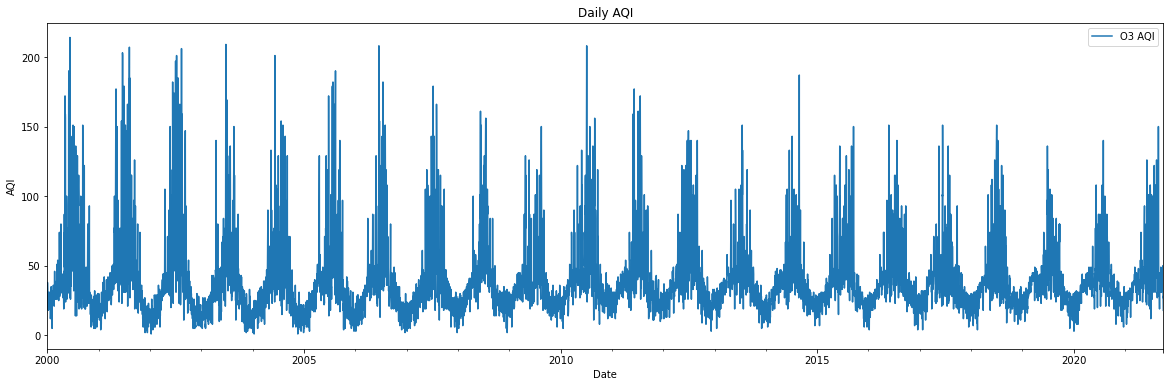

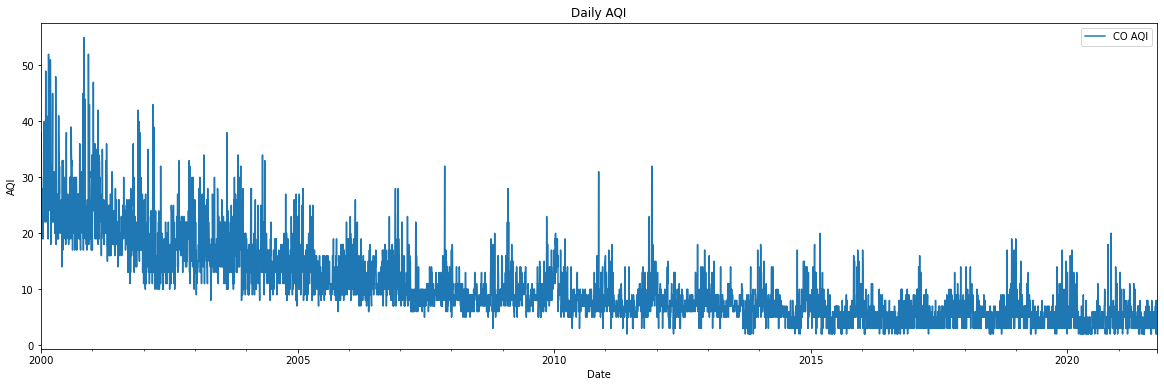

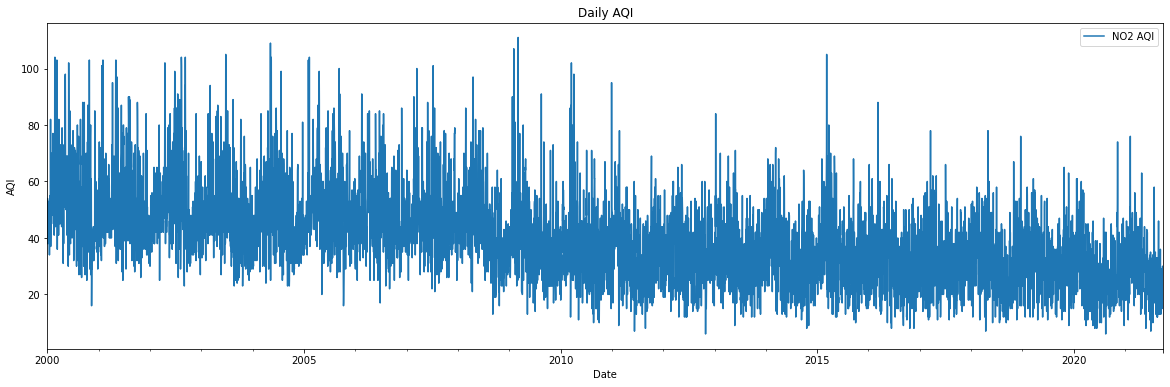

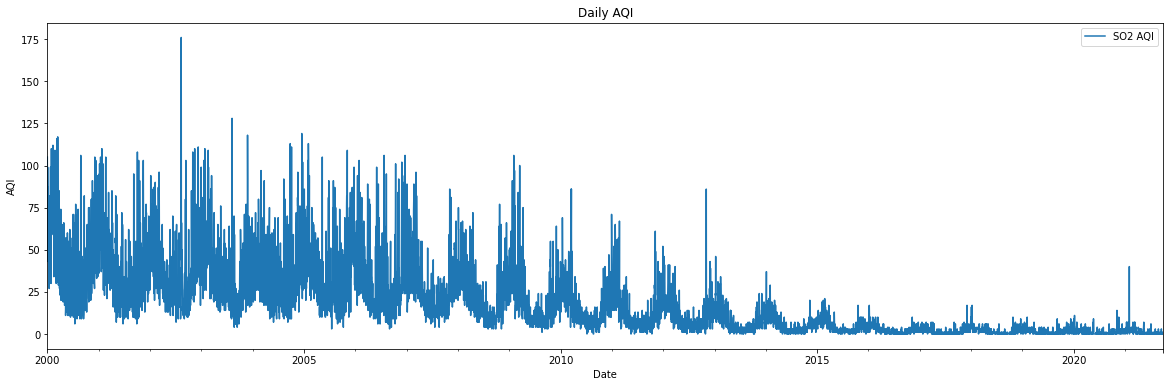

In [9]:
# Plotting daily AQI
for df in dailys:
    df.plot(figsize=(20,6))
    plt.title('Daily AQI')
    plt.xlabel('Date')
    plt.ylabel('AQI')
    plt.legend();

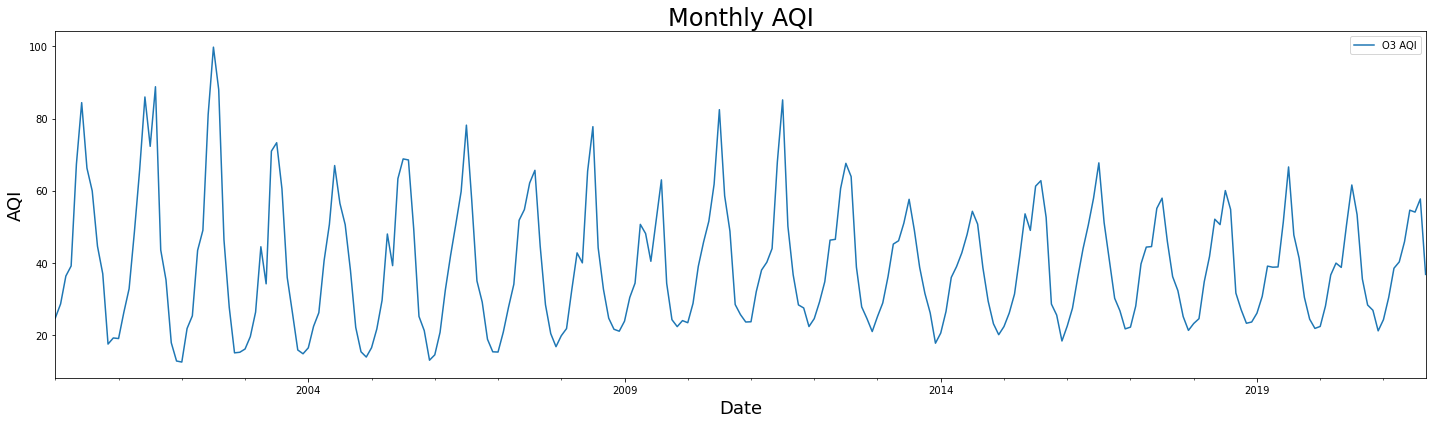

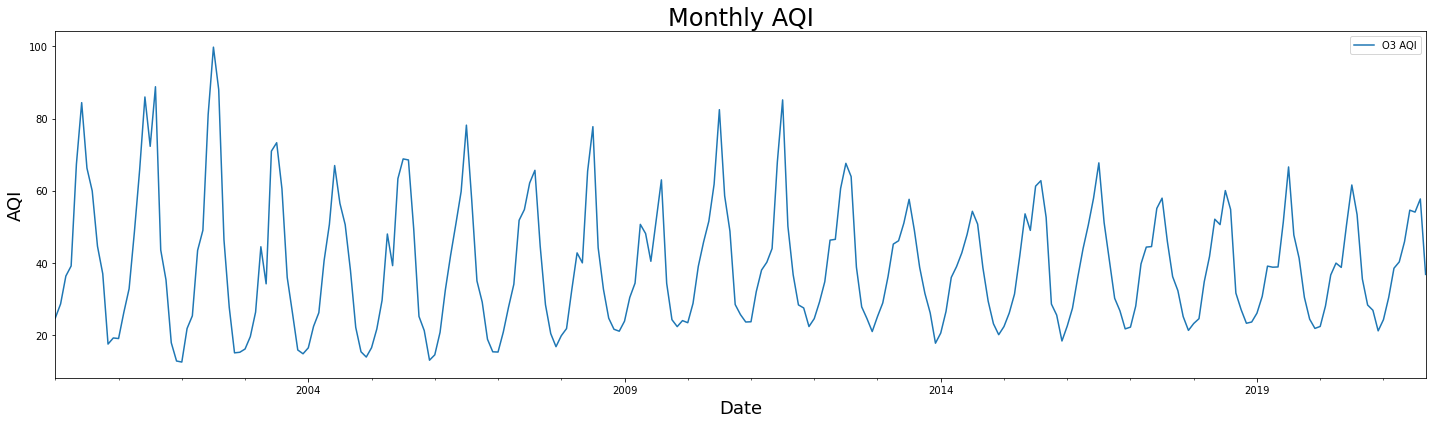

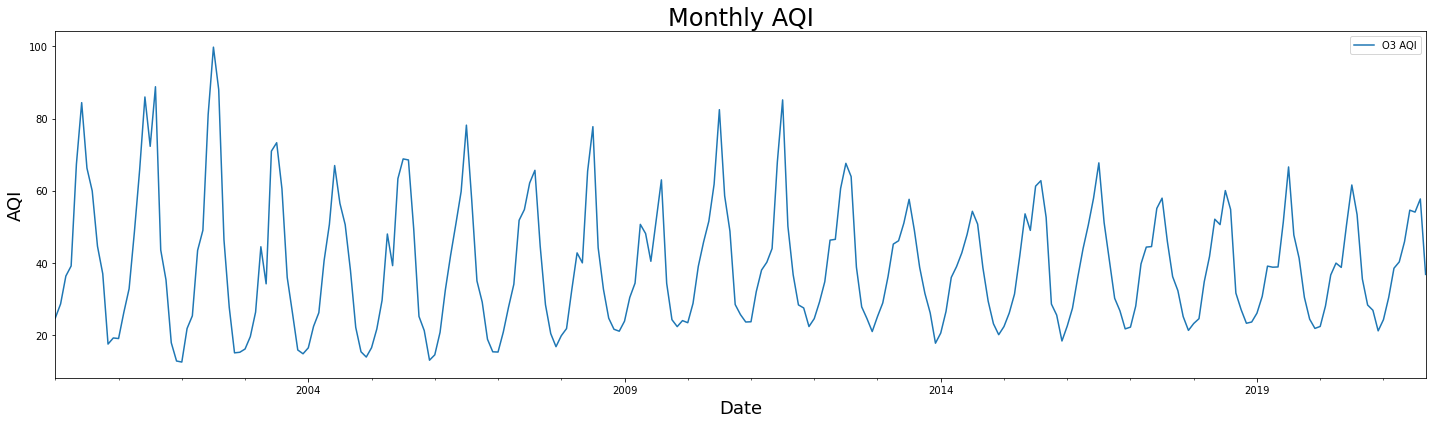

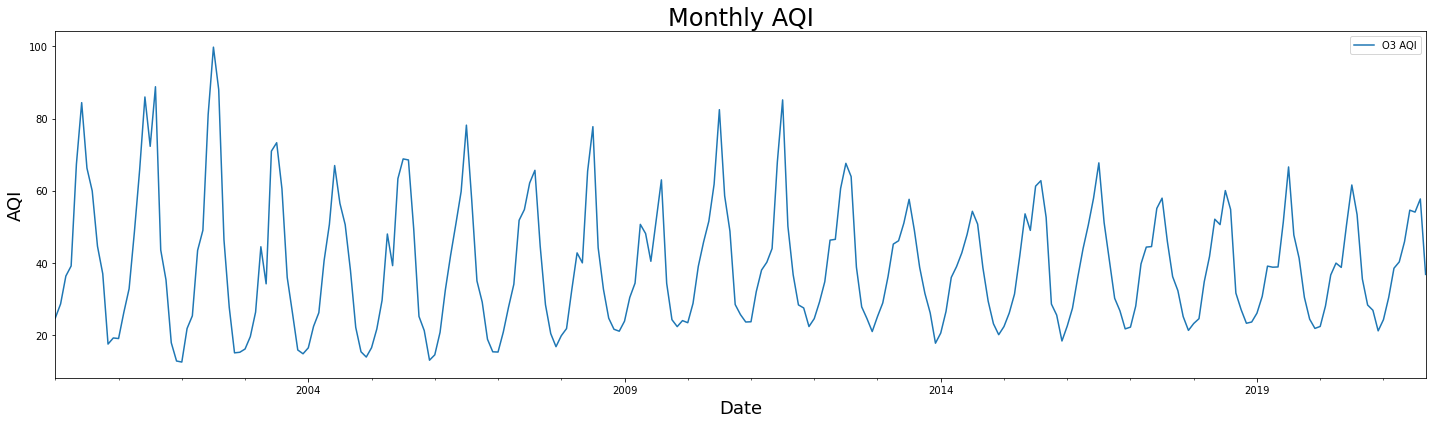

In [10]:
# Plotting monthly AQI
for df in monthlys:
    df.plot(figsize=(20,6))
    plt.title('Monthly AQI', fontsize=24)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('AQI', fontsize=18)
    plt.legend()
    plt.tight_layout();

In [11]:
# Log
monthlyCO_log = np.log(monthlyCO)
monthlyO3_log = np.log(monthlyO3)
monthlyNO2_log = np.log(monthlyNO2)
monthlySO2_log = np.log(monthlySO2)

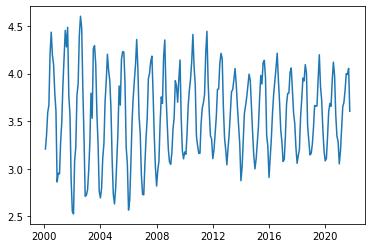

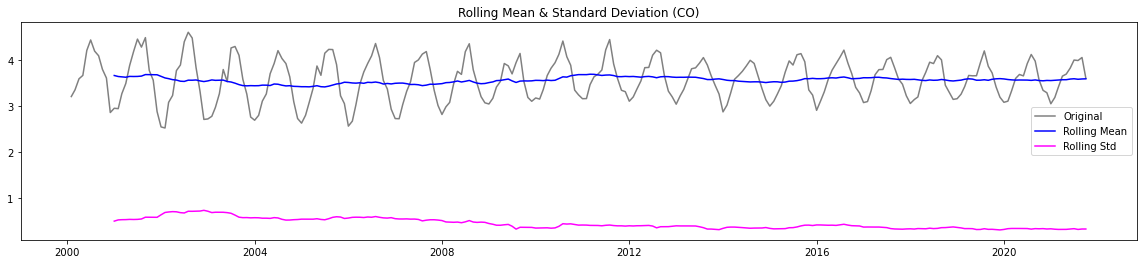

Results of Dickey-Fuller Test: 

Test Statistic             -2.153275
p-value                     0.223639
# of Lags Used             15.000000
# of Observations Used    245.000000
Critical Value (1%)        -3.457326
Critical Value (5%)        -2.873410
Critical Value (10%)       -2.573096
dtype: float64


In [13]:
# Testing with CO
plt.plot(monthlyCO_log)
stationarity_check(monthlyCO_log, 'CO')

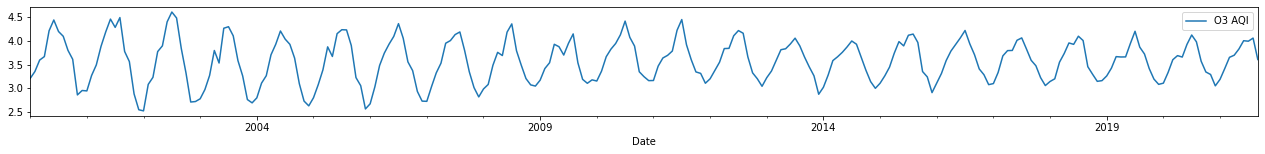

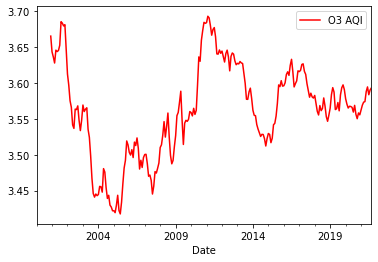

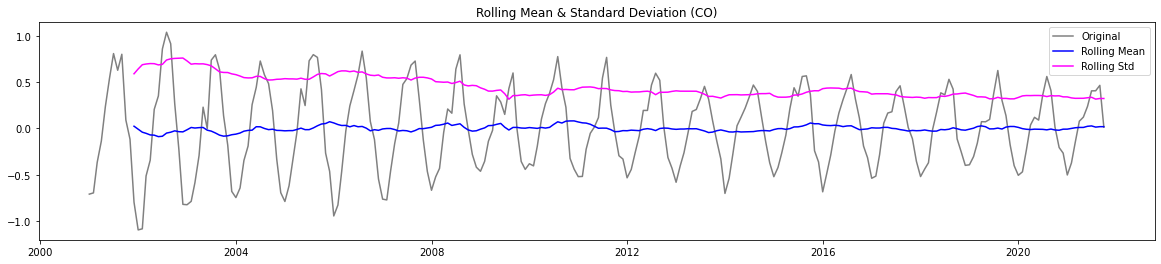

Results of Dickey-Fuller Test: 

Test Statistic             -4.894367
p-value                     0.000036
# of Lags Used             14.000000
# of Observations Used    235.000000
Critical Value (1%)        -3.458487
Critical Value (5%)        -2.873919
Critical Value (10%)       -2.573367
dtype: float64


In [14]:
# Moving average
moving_avg = monthlyCO_log.rolling(window=12).mean()
monthlyCO_log.plot(figsize=(22,2))
moving_avg.plot(color='red')
monthlyCO_log_moving_avg_diff = monthlyCO_log - moving_avg
monthlyCO_log_moving_avg_diff.dropna(inplace=True)

stationarity_check(monthlyCO_log_moving_avg_diff, 'CO')

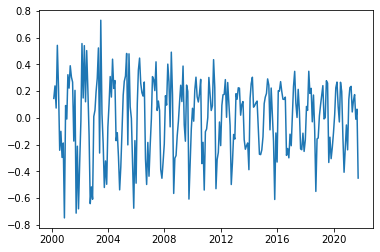

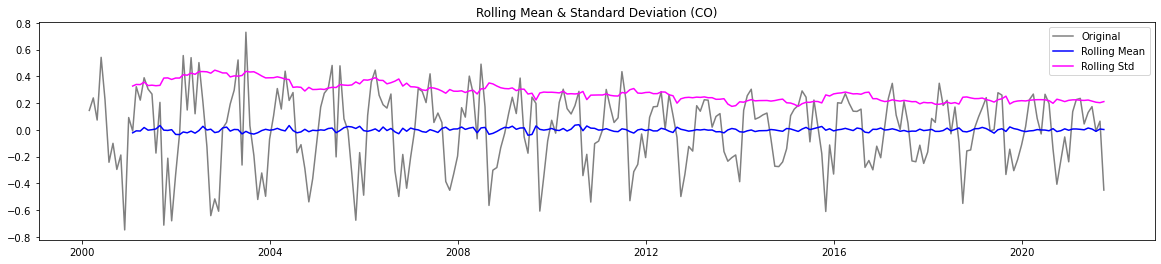

Results of Dickey-Fuller Test: 

Test Statistic           -7.267124e+00
p-value                   1.624025e-10
# of Lags Used            1.400000e+01
# of Observations Used    2.450000e+02
Critical Value (1%)      -3.457326e+00
Critical Value (5%)      -2.873410e+00
Critical Value (10%)     -2.573096e+00
dtype: float64


In [15]:
# Eliminating Trend and Seasonality
# First order differencing 
monthlyCO_log_diff = monthlyCO_log - monthlyCO_log.shift()
plt.plot(monthlyCO_log_diff)
monthlyCO_log_diff.dropna(inplace=True)
stationarity_check(monthlyCO_log_diff, 'CO')

In [18]:
# Decompose 

# NEED TO FIX #

# monthlyCO_log_decompose = seasonal_decompose(monthlyCO_log).resid
# monthlyCO_log_decompose.dropna(inplace=True)
# stationarity_check(monthlyCO_log_decompose, 'CO')

IndexingError: Too many indexers

In [19]:
# ACF and PACF
lag_acf = acf(monthlyCO_log_diff, nlags=20)
lag_pacf = pacf(monthlyCO_log_diff, nlags=20, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

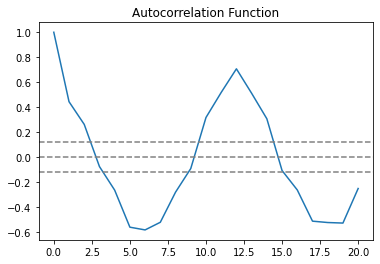

In [20]:
#Plot ACF: 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

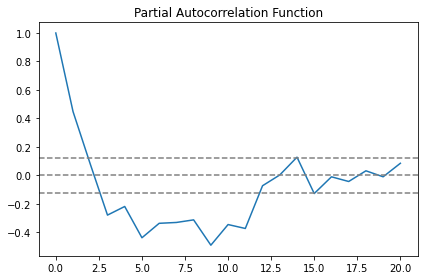

In [21]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

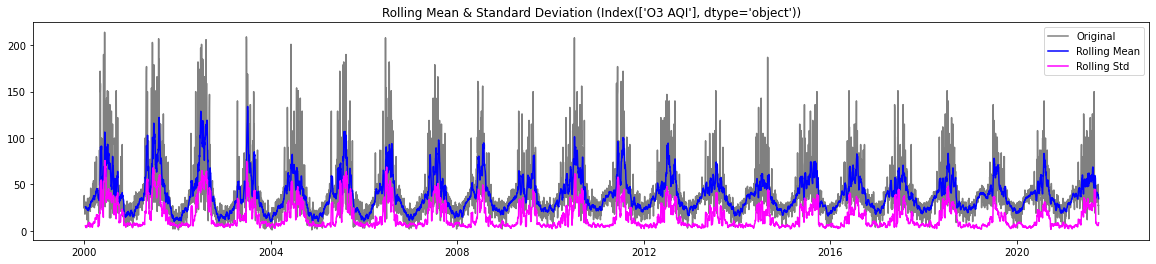

Results of Dickey-Fuller Test: 

Test Statistic           -6.420012e+00
p-value                   1.801269e-08
# of Lags Used            2.900000e+01
# of Observations Used    7.914000e+03
Critical Value (1%)      -3.431177e+00
Critical Value (5%)      -2.861905e+00
Critical Value (10%)     -2.566964e+00
dtype: float64


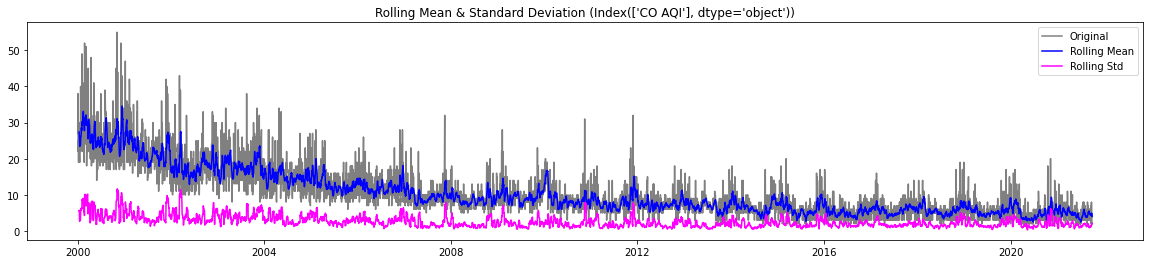

Results of Dickey-Fuller Test: 

Test Statistic              -3.077750
p-value                      0.028244
# of Lags Used              36.000000
# of Observations Used    7908.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


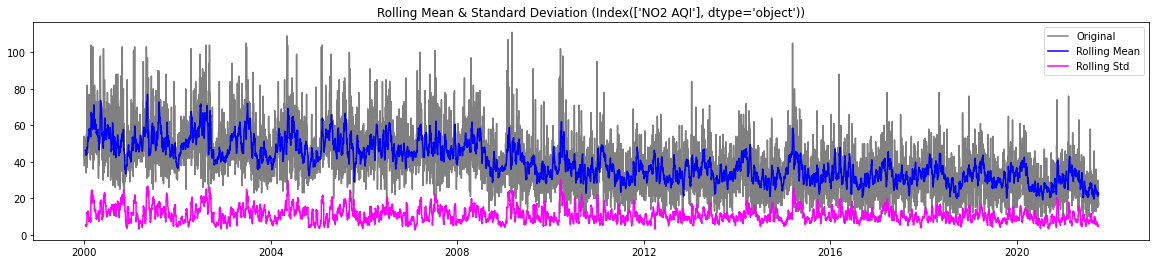

Results of Dickey-Fuller Test: 

Test Statistic              -4.521453
p-value                      0.000180
# of Lags Used              34.000000
# of Observations Used    7909.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


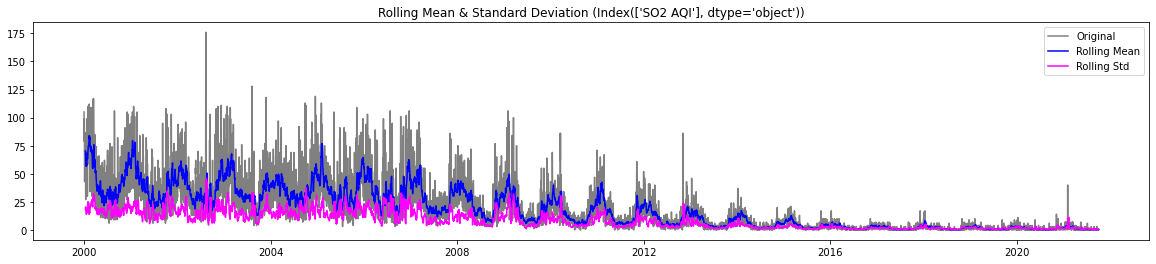

Results of Dickey-Fuller Test: 

Test Statistic              -3.791089
p-value                      0.003000
# of Lags Used              33.000000
# of Observations Used    7910.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861905
Critical Value (10%)        -2.566965
dtype: float64


In [27]:
i=0
for df in dflist:
    stationarity_check(df, df.columns)
    i+=1

# <span style="font-size:1.2em;"> <a id="Modeling">Modeling</a>

In [ ]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

RMSE = 43.9164061439

In [28]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [29]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2],12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1405.7318711951268
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1049.9027664601454
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-190.38598351537388
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-239.25815310399173
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-188.22496847209828
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-238.10826783165695
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-211.4705870463608
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-240.13490305733322
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1076.61016404106
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:745.4685108380256
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-205.1643108529575
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-266.1692213282229
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-204.9056941577859
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-266.38657836810813
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-234.575960297875
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-267.89461743720875
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:74.49993943234162
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-30.37665

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-188.77240397490112
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-125.46187693633416
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-200.32902579741696
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-145.84441950249015
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-191.85655762872793
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:37.40044064340006
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-34.869372524518894
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-179.18261017457368
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-249.82642940061416
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-191.9417458007179
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-278.91711013880666
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-212.7742254669835
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-241.41933317548552
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:75.76192054644073
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-28.113000060862667
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-204.1398996530772
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-273.2957659002493
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-2

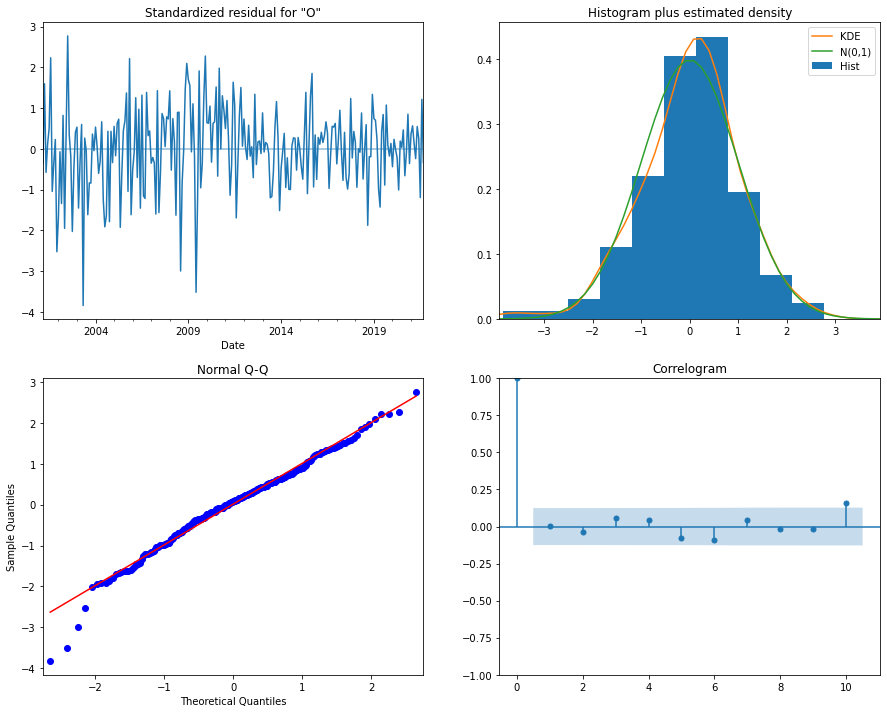

In [30]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(monthlyCO_log,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        
mod = SARIMAX(monthlyCO_log,
              order=(1,0,1),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

<Figure size 1584x432 with 0 Axes>

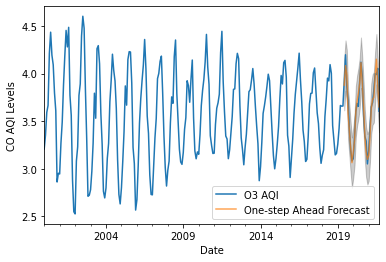

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
fig = plt.figure(figsize=(22,6))
ax = monthlyCO_log['2000':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI Levels')
plt.legend()
plt.show()

In [32]:
monthlyCO_forecasted = np.exp(pred.predicted_mean)
monthlyCO_truth = np.exp(monthlyCO_log['2015-06-30 00:00:00':])

"""
NEED TO FIX THIS
"""

# Compute the mse and rmse
mse =( (monthlyCO_forecasted - monthlyCO_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 2019-06-30 00:00:00   NaN
2019-07-31 00:00:00   NaN
2019-08-31 00:00:00   NaN
2019-09-30 00:00:00   NaN
2019-10-31 00:00:00   NaN
2019-11-30 00:00:00   NaN
2019-12-31 00:00:00   NaN
2020-01-31 00:00:00   NaN
2020-02-29 00:00:00   NaN
2020-03-31 00:00:00   NaN
2020-04-30 00:00:00   NaN
2020-05-31 00:00:00   NaN
2020-06-30 00:00:00   NaN
2020-07-31 00:00:00   NaN
2020-08-31 00:00:00   NaN
2020-09-30 00:00:00   NaN
2020-10-31 00:00:00   NaN
2020-11-30 00:00:00   NaN
2020-12-31 00:00:00   NaN
2021-01-31 00:00:00   NaN
2021-02-28 00:00:00   NaN
2021-03-31 00:00:00   NaN
2021-04-30 00:00:00   NaN
2021-05-31 00:00:00   NaN
2021-06-30 00:00:00   NaN
2021-07-31 00:00:00   NaN
2021-08-31 00:00:00   NaN
2021-09-30 00:00:00   NaN
O3 AQI                NaN
dtype: float64
The RMSE of our forecasts is 2019-06-30 00:00:00   NaN
2019-07-31 00:00:00   NaN
2019-08-31 00:00:00   NaN
2019-09-30 00:00:00   NaN
2019-10-31 00:00:00   NaN
2019-11-30 00:00:00   NaN
201

In [33]:
"""
NEED TO FIX THIS
"""
MASE(monthlyCO_truth, monthlyCO_truth, monthlyCO_forecasted)

2019-06-30 00:00:00   NaN
2019-07-31 00:00:00   NaN
2019-08-31 00:00:00   NaN
2019-09-30 00:00:00   NaN
2019-10-31 00:00:00   NaN
2019-11-30 00:00:00   NaN
2019-12-31 00:00:00   NaN
2020-01-31 00:00:00   NaN
2020-02-29 00:00:00   NaN
2020-03-31 00:00:00   NaN
2020-04-30 00:00:00   NaN
2020-05-31 00:00:00   NaN
2020-06-30 00:00:00   NaN
2020-07-31 00:00:00   NaN
2020-08-31 00:00:00   NaN
2020-09-30 00:00:00   NaN
2020-10-31 00:00:00   NaN
2020-11-30 00:00:00   NaN
2020-12-31 00:00:00   NaN
2021-01-31 00:00:00   NaN
2021-02-28 00:00:00   NaN
2021-03-31 00:00:00   NaN
2021-04-30 00:00:00   NaN
2021-05-31 00:00:00   NaN
2021-06-30 00:00:00   NaN
2021-07-31 00:00:00   NaN
2021-08-31 00:00:00   NaN
2021-09-30 00:00:00   NaN
O3 AQI                NaN
dtype: float64

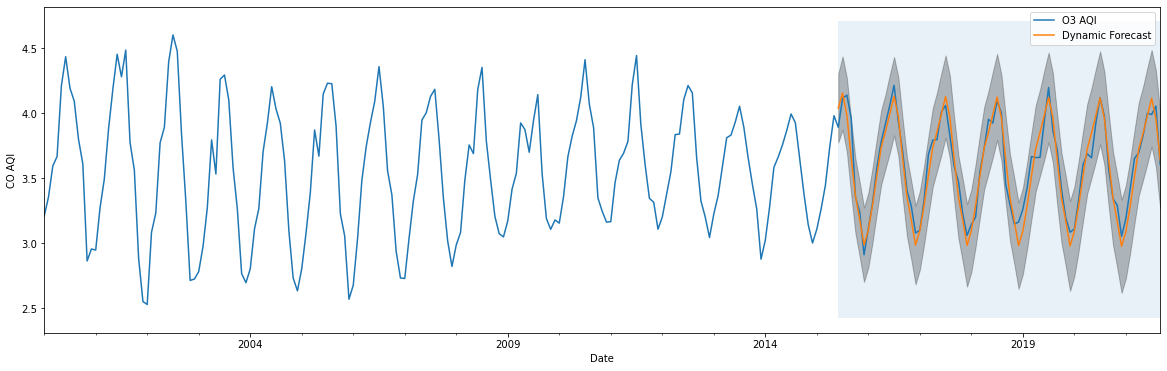

In [34]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = monthlyCO_log['2000':].plot(label='Observed', figsize=(20, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-06-30 00:00:00'), monthlyCO_log.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()

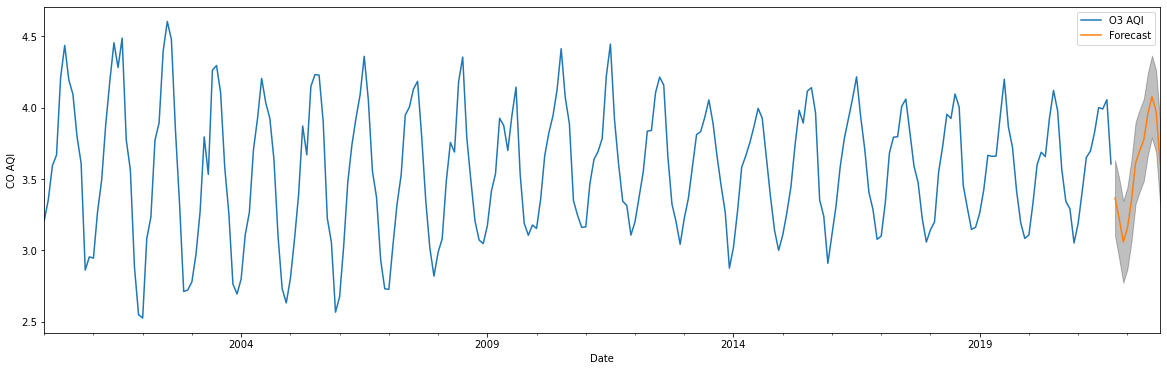

2021-10-31    28.979525
2021-11-30    25.121578
2021-12-31    21.329729
2022-01-31    23.430168
2022-02-28    28.515018
2022-03-31    37.066680
2022-04-30    40.354170
2022-05-31    43.521529
2022-06-30    52.274135
2022-07-31    58.965172
2022-08-31    53.177577
2022-09-30    36.902761
Freq: M, Name: predicted_mean, dtype: float64

In [35]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = monthlyCO_log.plot(label='Observed', figsize=(20, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()


np.exp(pred_uc.predicted_mean)

In [ ]:
arma = ARMA_model(O3, 'O3')

# mod_arma = ARMA(O3, order=(1,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(1,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arima = ARIMA(O3, order=(1,1,1), freq='D')
# O3_arima = mod_arima.fit()
# print(O3_arima.summary())

# mod_sarimax = SARIMAX(O3, order=(1,1,1), freq='D')
# O3_sarimax = mod_sarimax.fit()
# print(O3_sarimax.summary())

# <span style="font-size:1.2em;"> <a id="Visualizations">Visualizations</a>

In [36]:
df = pd.merge(O3, CO, how='inner', left_index=True, right_index=True)
df = pd.merge(df, NO2, how='inner', left_index=True, right_index=True)
df = pd.merge(df, SO2, how='inner', left_index=True, right_index=True)

df

,O3 AQI,CO AQI,NO2 AQI,SO2 AQI
Date,,,,
2000-01-01,25,27.0,38,105.0
2000-01-02,38,36.0,54,79.0
2000-01-03,31,38.0,47,99.0
2000-01-04,29,33.0,52,82.0
2000-01-05,24,22.0,42,43.0
...,...,...,...,...
2021-09-26,38,6.0,26,0.0
2021-09-27,50,3.0,22,1.0
2021-09-28,27,3.0,26,1.0


In [37]:
# Creating list of daily AQI per pollutant
dailys = [df['O3 AQI'], df['CO AQI'], df['NO2 AQI'], df['SO2 AQI']]

# Downsampling from days to months
monthlyO3 = df.copy()['O3 AQI'].resample('M').mean()
monthlyCO = df.copy()['CO AQI'].resample('M').mean()
monthlyNO2 = df.copy()['NO2 AQI'].resample('M').mean()
monthlySO2 = df.copy()['SO2 AQI'].resample('M').mean()

# Creating list of monthly AQI per pollutant
monthlys = [monthlyO3, monthlyCO, monthlyNO2, monthlySO2]

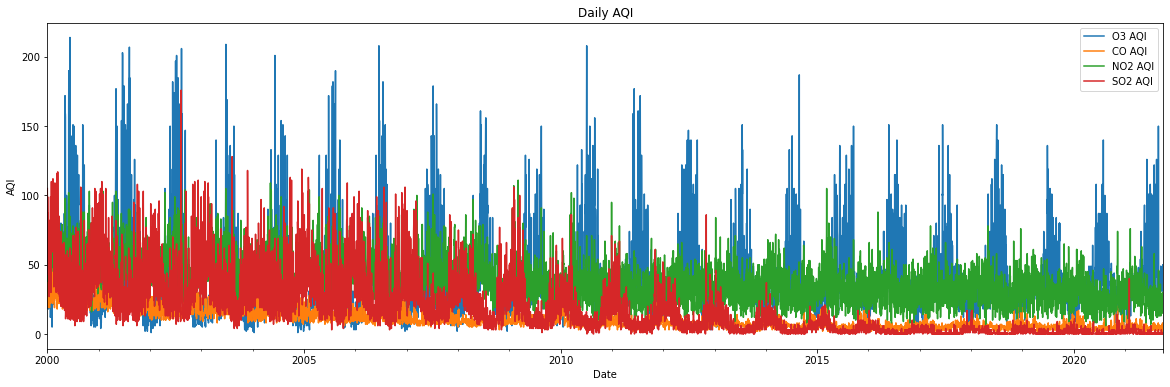

In [38]:
# Plotting daily AQI
for df in dailys:
    df.plot(figsize=(20,6))
    plt.title('Daily AQI')
    plt.ylabel('AQI')
    plt.legend();

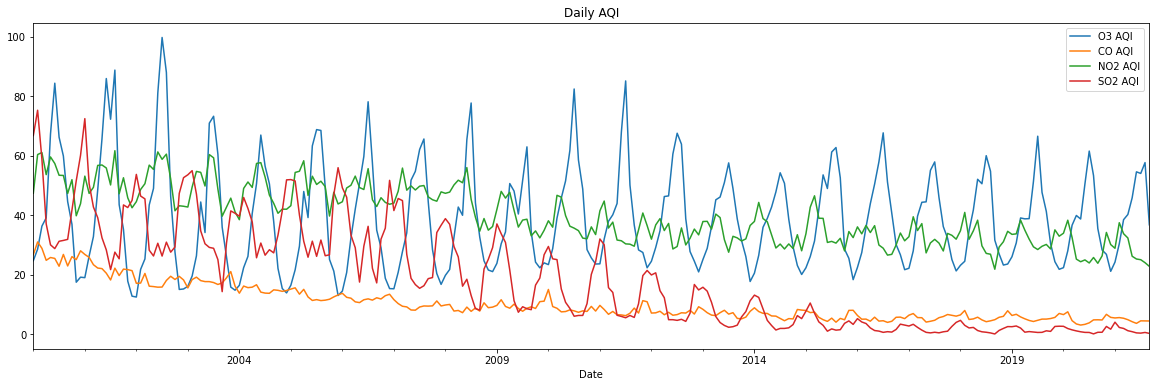

In [40]:
# Plotting daily AQI
for df in monthlys:
    df.plot(figsize=(20,6))
    plt.title('Daily AQI')
    plt.legend();

# <span style="font-size:1.2em;"> <a id="Conclusion">Conclusion</a>

> In conclusion, my SARIMA model forecasted air quality in New York City quite well and could even be used in shaping government policy on public health. I would recommend implementing measures to decrease the presence of air pollutants, especially ozone and nitrogen dioxide, as there hasn't been much decrease from 2000.

# <span style="font-size:1.2em;"> <a id="Next Steps">Next Steps</a>

> Given more time and resources, I would like to explore beyond New York City, modeling for other cities and even seeing how cities compare to suburban or rural areas. Another pollutant I'd like to consider is particulate matter. In terms of modeling, it would be interesting to see how well a recurrent neural network would perform.

Function sources:

https://www.kaggle.com/victoraqiao/time-series-forecasting-arima-co-aqi

MASE:
https://github.com/scikit-learn/scikit-learn/issues/18685